<a href="https://colab.research.google.com/github/linhlinhle997/AIO2024_Exercises/blob/feature%2Fexercices-module06/module06/week04_Transformer/flowers_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install evaluate
!pip install torchtext

In [ ]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer

import evaluate

## Load Dataset

In [ ]:
!gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
!unzip ./flower_photos.zip

In [ ]:
dataset = ImageFolder(root="/kaggle/working/flower_photos")

classes = dataset.classes
num_samples = len(dataset)
num_classes = len(dataset.classes)

print("Classes: ", classes)
num_samples, num_classes

Classes:  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


(3670, 5)

In [ ]:
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1

n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples

train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)

len(train_dataset), len(valid_dataset), len(test_dataset)

(2936, 367, 367)

## Preprocessing

In [ ]:
IMG_SIZE = 224

# Resize and convert to tensor
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Apply
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

## DataLoader

In [ ]:
BATCH_SIZE = 512

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

len(train_loader), len(valid_loader), len(test_loader)

(6, 1, 1)

## Model Training, Evaluation, and Plotting Functions

In [ ]:
def train_epoch(model, optimizer, criterion, dataloader, device, epoch=0, log_interval=50):
    model.train()

    total_acc, total_count = 0, 0
    losses = []
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        preds = model(inputs)
        loss = criterion(preds, labels) # Calculate loss
        losses.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        total_acc += (preds.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        # Log progress
        if idx % log_interval == 0 and idx > 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0

    # Calculate epoch metrics
    epoch_acc = total_acc / total_count
    epoch_loss = np.mean(losses)

    return epoch_acc, epoch_loss


def evaluate_epoch(model, criterion, dataloader, device):
    model.eval()

    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            preds = model(inputs)
            loss = criterion(preds, labels)
            losses.append(loss.item())

            total_acc += (preds.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = np.mean(losses)

    return epoch_acc, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []

    best_lost_eval = 100

    for epoch in range(1, num_epochs + 1):

        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_lost_eval:
            best_lost_eval = eval_loss
            torch.save(model.state_dict(), save_model + f"/{model_name}.pt")

        # Log progress
        print("=" * 50)
        print("| End of epoch {:3d} | Train Accuracy {:8.3f} | Train Loss {:8.3f} | Valid Accuracy {:8.3f} | Valid Loss {:8.3f}".format(epoch, train_acc, train_loss, eval_acc, eval_loss))
        print("=" * 50)

    # Load best model
    model.load_state_dict(torch.load(save_model + f"/{model_name}.pt"))
    model.eval()
    return model, train_accs, train_losses, eval_accs, eval_losses

In [ ]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].plot(num_epochs, train_accs, label="Training")
    ax[0].plot(num_epochs, eval_accs, label="Evaluation")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(num_epochs, train_losses, label="Training")
    ax[1].plot(num_epochs, eval_losses, label="Evaluation")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.legend()
    plt.show()

## Training from Scratch

### Modeling

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_ouput = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

In [ ]:
class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device="cpu"):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = embed_dim ** -0.5
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2, embed_dim))
        self.device = device

    def forward(self, x):
        x = self.conv1(x) # shape [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1) # shape [*, width, grid ** 2]
        x = x.permute(0, 2, 1) # shape [*, grid **2, width]
        x = x + self.positional_embedding.to(self.device)
        return x

In [ ]:
class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, dropout=0.1, num_classes=10, patch_size=16, device="cpu"):
        super().__init__()
        self.embed_layer = PatchPositionEmbedding(image_size=image_size, embed_dim=embed_dim, patch_size=patch_size, device=device)
        self.transformer_layer = TransformerEncoder(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.embed_layer(x)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :]
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

### Training

In [ ]:
image_size = 224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformerCls(
    image_size=image_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout=dropout,
    num_classes=num_classes,
    device=device
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
num_epochs = 100
model_name = "vit_flowers"
save_model = "./vit_flowers"
os.makedirs(save_model, exist_ok=True)

model, train_accs, train_losses, eval_accs, eval_losses = train(model, model_name, save_model, optimizer, criterion, train_loader, valid_loader, num_epochs, device)

| End of epoch   1 | Train Accuracy    0.294 | Train Loss    1.674 | Valid Accuracy    0.373 | Valid Loss    1.425
| End of epoch   2 | Train Accuracy    0.369 | Train Loss    1.424 | Valid Accuracy    0.398 | Valid Loss    1.341
| End of epoch   3 | Train Accuracy    0.410 | Train Loss    1.315 | Valid Accuracy    0.401 | Valid Loss    1.288
| End of epoch   4 | Train Accuracy    0.439 | Train Loss    1.283 | Valid Accuracy    0.420 | Valid Loss    1.257
| End of epoch   5 | Train Accuracy    0.468 | Train Loss    1.242 | Valid Accuracy    0.441 | Valid Loss    1.247
| End of epoch   6 | Train Accuracy    0.472 | Train Loss    1.221 | Valid Accuracy    0.447 | Valid Loss    1.195
| End of epoch   7 | Train Accuracy    0.491 | Train Loss    1.187 | Valid Accuracy    0.474 | Valid Loss    1.191
| End of epoch   8 | Train Accuracy    0.503 | Train Loss    1.153 | Valid Accuracy    0.504 | Valid Loss    1.152
| End of epoch   9 | Train Accuracy    0.517 | Train Loss    1.129 | Valid Accur

<ipython-input-10-372163ec503b>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model + f"/{model_name}.pt"))


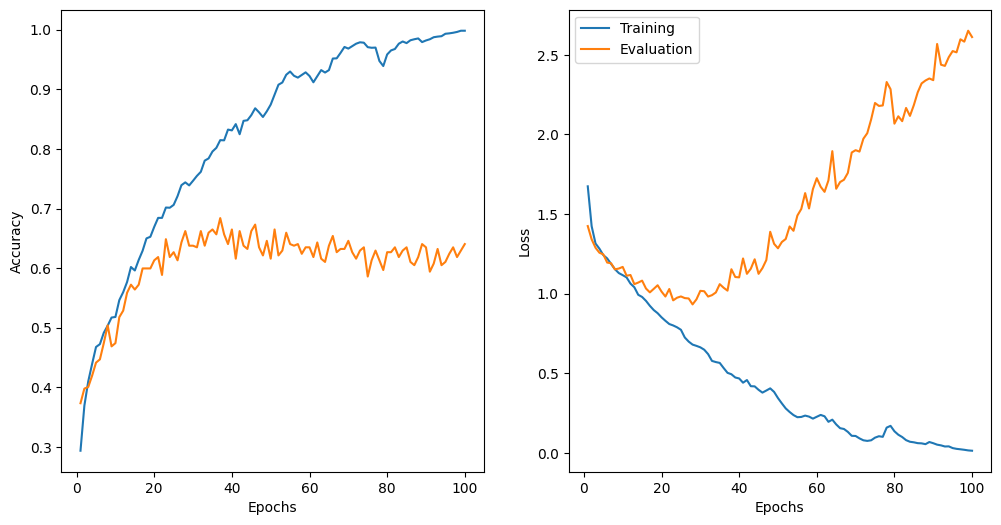

In [ ]:
num_epochs = np.arange(1, 101)

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

## Fine Tuning

### Model

In [ ]:
id2label = {id:label for id, label in enumerate(classes)}
label2id = {label:id for id, label in id2label.items()}

id2label, label2id

({0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'},
 {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Metric

In [ ]:
metric = evaluate.load("accuracy")

# Metric computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

### Trainer

In [ ]:
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

metric_name = "accuracy"

args = TrainingArguments(
    f"vit_flowers",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir="logs",
    remove_unused_columns=False
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
# Data collator function
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor
)

trainer.train()
outputs = trainer.predict(test_dataset)
outputs.metrics

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.535022,0.967302
2,No log,0.259203,0.967302
3,No log,0.190801,0.970027
4,No log,0.176133,0.967302
5,No log,0.174180,0.967302
6,0.329000,0.155060,0.967302
7,0.329000,0.152801,0.964578
8,0.329000,0.150089,0.967302
9,0.329000,0.150838,0.967302
10,0.329000,0.151796,0.967302


{'test_loss': 0.1982872188091278,
 'test_accuracy': 0.9700272479564033,
 'test_runtime': 3.3495,
 'test_samples_per_second': 109.57,
 'test_steps_per_second': 3.583}